In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Disgten example

Similar to the simple example, but generating particles with Distgen

In [3]:
from distgen import Generator
YAML="""

n_particle: 10000
random_type: hammersley

start:
  type: cathode
  MTE:
    value: 414
    units: meV    

total_charge:
  value: 250
  units: pC
    
r_dist:
  n_sigma_cutoff: 1.5
  sigma_xy:
    value: 0.4
    units: mm
  type: radial_gaussian

t_dist:
  type: superposition
  dists: 
    d1: 
      type: gaussian
      avg_t:
        units: ps
        value: -1
      sigma_t:
        units: ps
        value: 1
    d2: 
      type: gaussian
      avg_t:
        units: ps
        value: 1
      sigma_t:
        units: ps
        value: 1
 

"""

G = Generator(YAML)

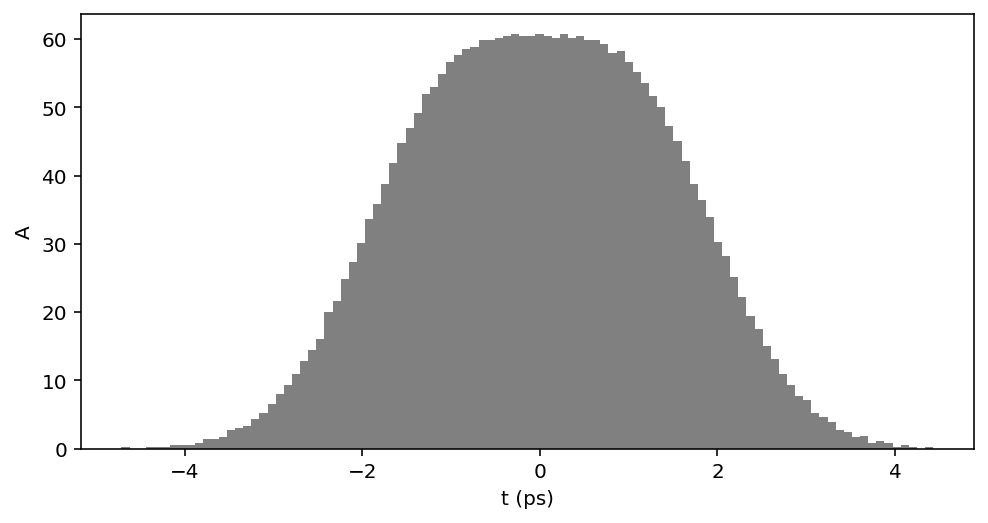

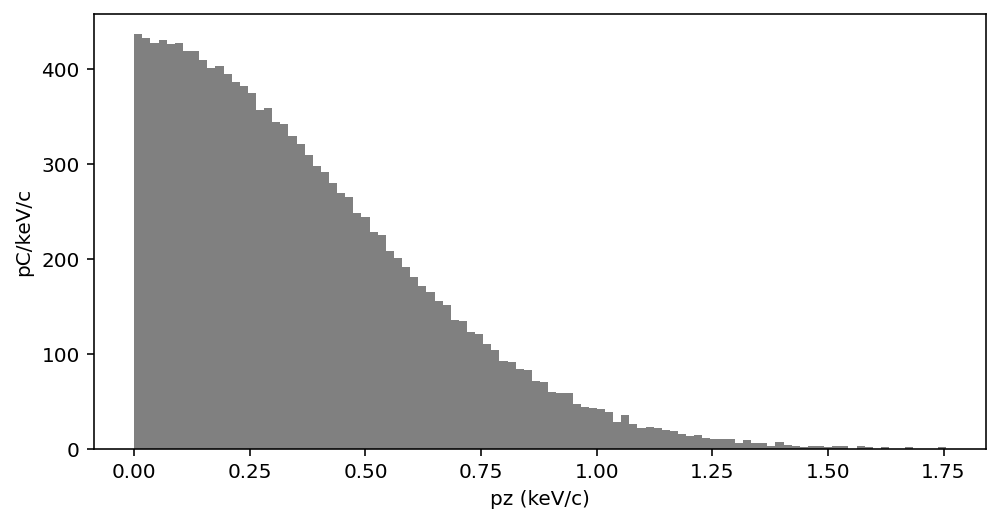

In [4]:
# Tune the two dist separation
G['t_dist:dists:d1:avg_t:value'] = -1
G['t_dist:dists:d2:avg_t:value'] = 1
G.run()
GP = G.particles
GP.plot('t')
GP.plot('pz')

In [5]:
from impact import Impact, template_dir

import matplotlib.pyplot as plt
import os

In [6]:
ifile = os.path.join(template_dir,'lcls_injector/ImpactT.in')
os.path.exists(ifile)

True

In [7]:
# Make Impact object
I = Impact(ifile, initial_particles = G.particles, verbose=True)

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpriwdavrf


In [8]:
# This will use the initial particles
I.write_initial_particles(update_header=True)

writing 10000 particles to /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpriwdavrf/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 10000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 9.145639807439135e-12 according to initial particles
Cathode start: Replaced Tini with -4.714953504413114e-12 according to initial particles
Setting total charge to 2.4999999999999996e-10 C


In [9]:
# Change some things
I.header['Nx'] = 16
I.header['Ny'] = 16
I.header['Nz'] = 16
I.header['Dt'] = 5e-13

# Turn Space Charge off
I.header['Bcurr'] = 0 

# Other switches
I.timeout = 1000
# Switches for MPI
I.use_mpi=True
I.header['Nprow'] = 1
I.header['Npcol'] = 4

In [10]:
# Change stop location
I.stop = 1.5
#I.ele['stop_1']['s'] = I.ele['OTR2']['s']+.001

Removed element: stop_1
Set stop to s = 1.5


In [11]:
I.run()

Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpriwdavrf
mpirun -n 4 /Users/chrisonian/Code/miniconda3/envs/devel/bin/ImpactTexe-mpi
writing 10000 particles to /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpriwdavrf/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 10000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 9.145639807439135e-12 according to initial particles
Cathode start: Replaced Tini with -4.714953504413114e-12 according to initial particles
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitude i

In [12]:
I.input.keys()

dict_keys(['original_input', 'input_particle_file', 'header', 'lattice', 'fieldmaps'])

In [13]:
I.output.keys()

dict_keys(['run_info', 'stats', 'slice_info', 'particles'])

In [14]:
I.output['stats'].keys()

dict_keys(['t', 'mean_z', 'moment4_x', 'moment4_y', 'moment4_z', 'mean_y', 'sigma_y', 'norm_emit_y', 'mean_x', 'sigma_x', 'norm_emit_x', 'sigma_z', 'norm_emit_z', 'loadbalance_min_n_particle', 'loadbalance_max_n_particle', 'n_particle', 'moment3_x', 'moment3_y', 'moment3_z', 'mean_gamma', 'mean_beta', 'max_r', 'sigma_gamma', 'max_amplitude_x', 'max_amplitude_y', 'max_amplitude_z', 'moment4_px', 'moment4_py', 'moment4_pz', 'mean_py', 'sigma_py', 'cov_y__py', 'mean_px', 'sigma_px', 'cov_x__px', 'mean_pz', 'sigma_pz', 'cov_z__pz', 'moment3_px', 'moment3_py', 'moment3_pz', 'mean_kinetic_energy', 'max_amplitude_px', 'max_amplitude_py', 'max_amplitude_pz'])

In [15]:
I.output['slice_info'].keys()

dict_keys(['final_particle_slices', 'initial_particle_slices'])

# Particles

In [16]:
# Particles are automatically parsed in to openpmd-beamphysics ParticleGroup objects
I.output['particles']

{'initial_particles': <ParticleGroup with 10000 particles at 0x12627c2e0>,
 'final_particles': <ParticleGroup with 10000 particles at 0x12627c520>,
 'YAG02': <ParticleGroup with 10000 particles at 0x12616da90>}

In [17]:
PI = I.output['particles']['initial_particles']
PF = I.output['particles']['final_particles']

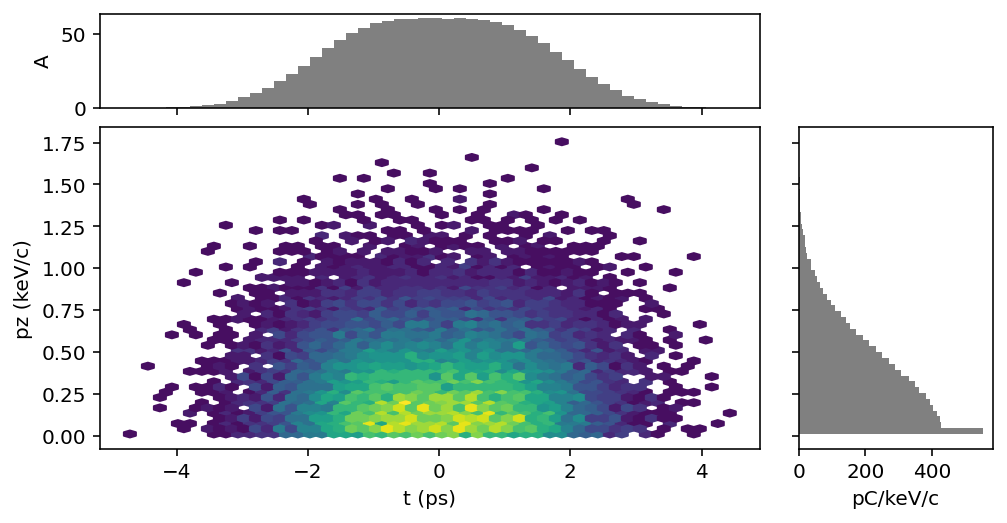

In [18]:
# Original particles
GP.plot('t', 'pz')

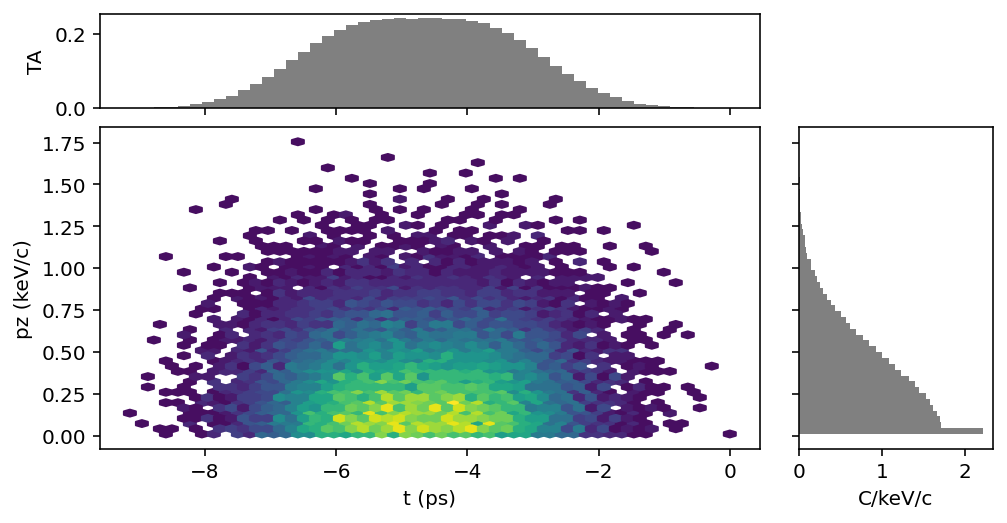

In [19]:
# Readback of initial particles from Impact-T. 
PI.plot('t', 'pz')

In [20]:
# The initial time was shifted to account for this
I.header['Tini']

-4.714953504413114e-12

In [21]:
# Get the final particles, calculate some statistic
P = I.output['particles']['final_particles']
P['mean_energy']

5996724.83031878

In [22]:
# Show the units
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

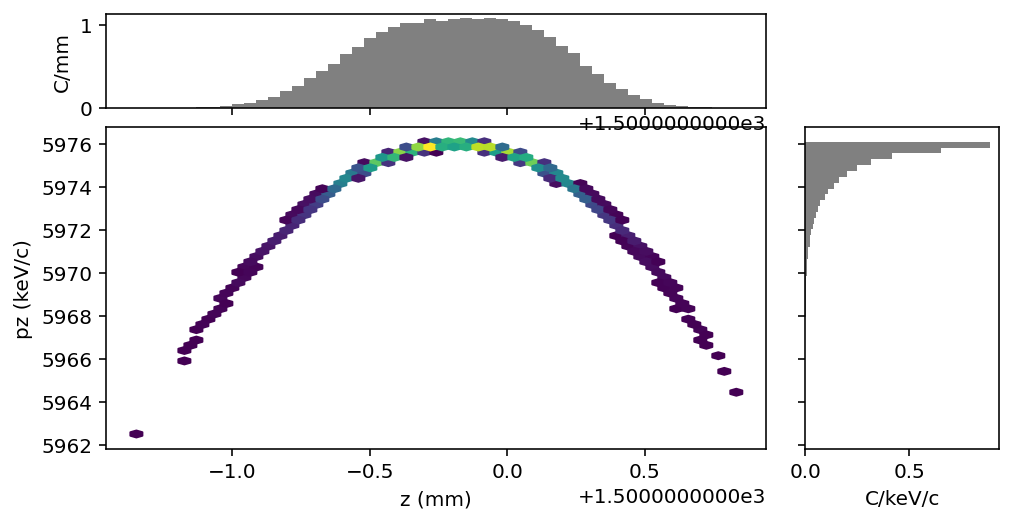

In [23]:
P.plot('z', 'pz')

# Stats

In [24]:
# Impact's own calculated statistics can be retieved
len(I.stat('norm_emit_x')), I.stat('norm_emit_x')[-1]

(631, 2.5687794e-07)

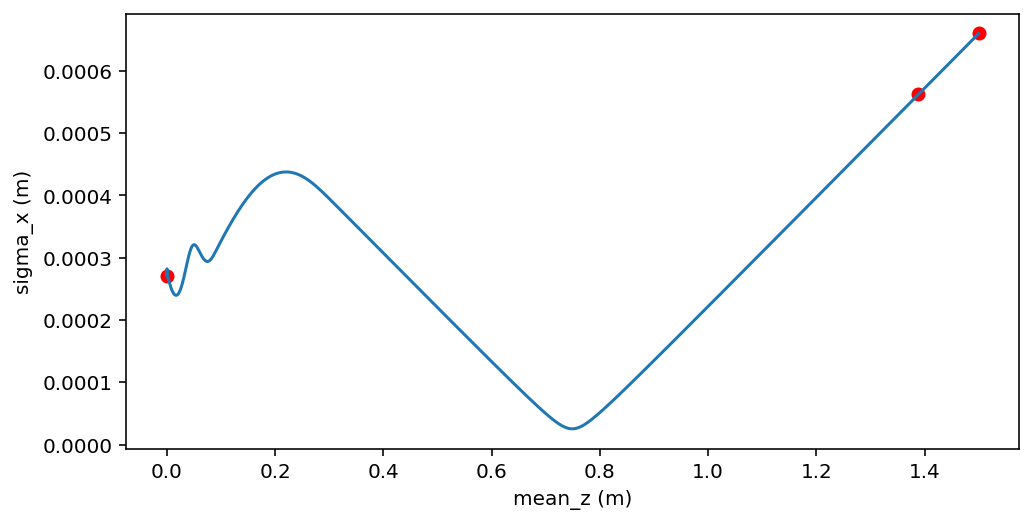

In [25]:
# Compare these. 
key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')

# Archive, and restart from the middle

In [26]:
afile = I.archive()
I2 = Impact(verbose=False)
I2.load_archive(afile)

# Patch in these particles
I2.initial_particles = I2.particles['YAG02']

# Turn off cathode start
I2.header['Flagimg'] = 0
I2.configure()


Archiving to file impact_782ca80a6d7beb8de652253e3702fb12.h5


In [27]:
# Run again
I2.use_mpi=True
I2.run()

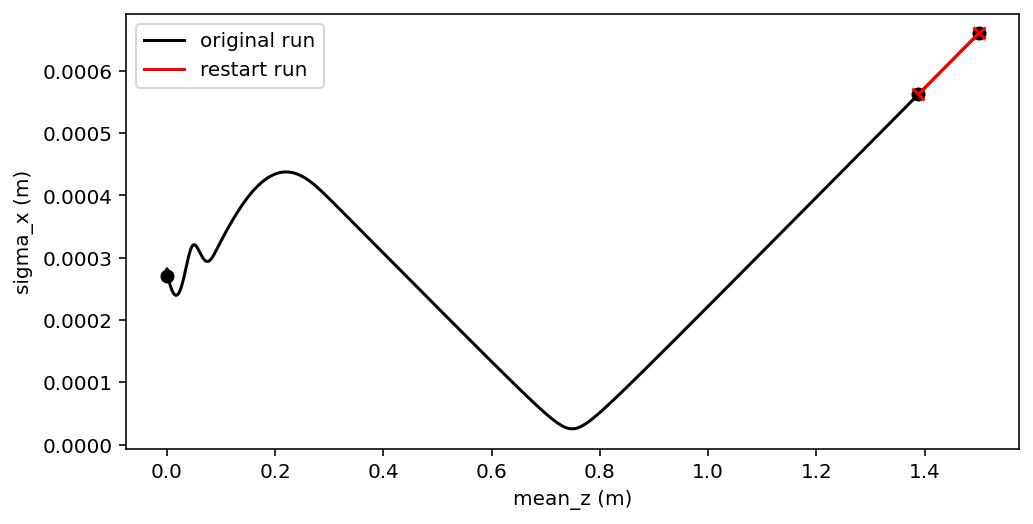

In [28]:
# Compare these. 
key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2), color='black', label='original run')
plt.plot(I2.stat(key1), I2.stat(key2), color='red', label='restart run')
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='black')

plt.scatter(
    [I2.particles[name][key1] for name in I2.particles], 
    [I2.particles[name][key2] for name in I2.particles], color='red', marker='x')
plt.legend()

In [29]:
# Cleanup
os.remove(afile)